### Machine Learning for Systems & Control 5SC28 2023-2024

# Exercise set for Lecture 7: Advanced Reinforcement Learning 

This exercise set illustrates two more advanced methods of $Q$-learning; basis function methods and deep $Q$-learning.

## Table of contents

1. <a href="#Exercise-1:-Basis-Function-$Q$-learning">Exercise 1: Basis Function $Q$-learning</a>
2. <a href="#Exercise-2:-Deep-$Q$-learning">Exercise 2: Deep $Q$-learning</a>


## Exercise 1: Basis Function $Q$-learning

As seen in the lecture, tabular $Q$-learning can be interpreted as minimizing the temporal difference (TD) given by:

$$
 \frac{1}{2} \text{TD}^2 = \frac{1}{2} \left (\left (r_k + \gamma \max_u Q_\theta(x_{k+1},u) \right )  - Q_\theta(x_k,u_k) \right)^2
$$

This mimization problem can be used to formulate a steepest descent update rule for continous $Q$ functions.  

**a)** Derive the steepest descent update rule which minimizes $\frac{1}{2} \text{TD}^2$ for the parameters $\theta$ where the $Q$-function has the form of the following basis function expansion $$ Q_\theta(x_k,u_k) = \phi(x_k) \cdot \theta_{u_k} $$ where $\theta_{u_k}$ is a vector for a given input $u_k$. [By considering the discrete and finite set of possible actions, we associate a specific parameter vector $\theta_{u_k}$ with each possible action $u_k$. This formulation allows us to compute the derivative of $Q_\theta(x_k,u_k)$ with respect to the parameter of the corresponding action, capturing the specific characteristics and policies associated with each action].

**Answer a):** 
Given the TD (temporal difference) defined as:

$\text{TD} = Q_\theta(x_k,u_k) - \left(r_k + \gamma \max_u Q_\theta(x_{k+1},u)\right)$

We want to derive the steepest descent update rule for the parameters $(\theta)$ based on the minimization of $\frac{1}{2}\text{TD}^2$.

1. Compute the gradient of $\frac{1}{2}\text{TD}^2$ with respect to the parameter $(\theta_i)$:
$$
\nabla_{\theta_i}\left(\frac{1}{2}\text{TD}^2\right)
$$

2. Expand $\text{TD}^2$ using the chain rule (similar to slides):
$$
\nabla_{\theta_i}\left(\frac{1}{2}\text{TD}^2\right) = \text{TD}\nabla_{\theta_i}Q_\theta(x_k,u_k)
$$

3. Note that $Q_\theta(x_k,u_k)$ has the form of a basis function expansion:
$$
Q_\theta(x_k,u_k) = \phi(x_k) \cdot \theta_{u_k}
$$
where $\phi(x_k)$ is the feature vector associated with the input state $x_k$ and $\theta_{u_k}$ is a vector for a given input $u_k$. Therefore, we have:
$$
\nabla_{\theta_i}Q_\theta(x_k,u_k) = \begin{cases} \phi(x_k) & \text{if  $u_k=u$  }\\ 0 & \text{otherwise} \end{cases}
$$

Let's assume that $\theta$ is a vector of parameters, and we are interested in computing the derivative of $Q_\theta(x_k,u_k)$ with respect to the $i$-th parameter, denoted as $\theta_i$.

If $u_k \neq u$, it means that $\theta_i$ is not related to the input $u$. Therefore, the derivative of $Q_\theta(x_k,u_k)$ with respect to $\theta_i$ is zero:
$$
\frac{\partial Q_\theta(x_k,u_k)}{\partial \theta_i} = 0
$$

On the other hand, if $u_k = u$, it means that $\theta_i$ corresponds to the parameter associated with the input $u$. In this case, the derivative of $Q_\theta(x_k,u_k)$ with respect to $\theta_i$ is $\phi(x_k)$:

$\frac{\partial Q_\theta(x_k,u_k)}{\partial \theta_i} = \phi(x_k)$

4. Substitute the gradient expression into the steepest descent update rule:
$$
\theta_u^+ = \theta_u - \alpha\phi(x_k)
$$
where $\alpha$ represents the learning rate, and $\theta_u^+$ denotes the updated value of the parameter $\theta_u$.


A common basis function for $Q$-learning is the normalized [radial basis function]
(https://en.wikipedia.org/wiki/Radial_basis_function)  (RBF) which is given by

$\psi_i(x_t) = \exp \left ( {-\frac{(x_t - c_i) B (x_t - c_i)^T}{2 \sigma_c^2}} \right )$

$\phi_i(x_t) = \frac{\psi_i(x_t)}{\sum_j \psi_j(x_t)}$

$B = diag(1/\Delta X_1^2, 1/\Delta X_2^2, ...)$

where $\Delta X_j$ is the grid spacing in each dimension.



**b)** Implement the RBF network function found below and validate the output for the 1D `my_gym` environment. (`scale` is the $\sigma_c$ parameter in the equation)

**c)** what happens when $\sigma_c$ gets close to zero? Does this look familiar?

**Answer c):** Yes; it converges to the discrete state case which was used in the previous exercise. 

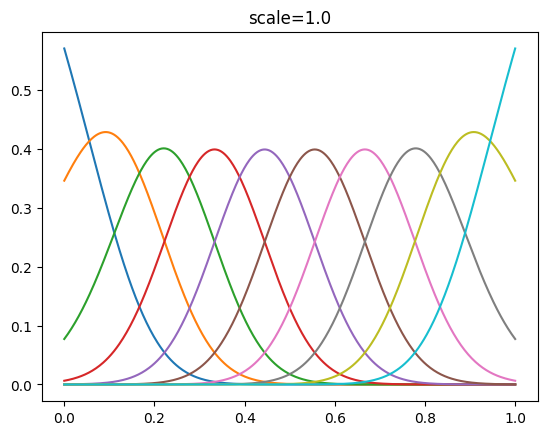

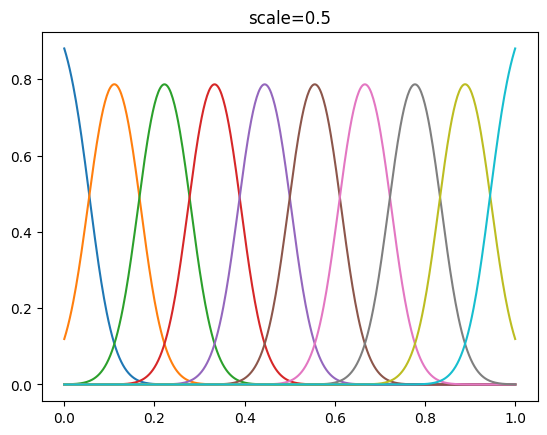

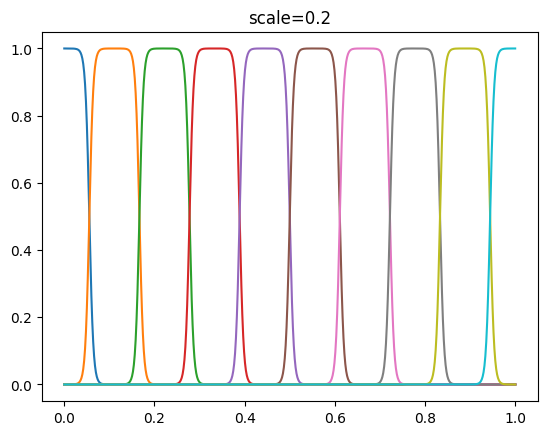

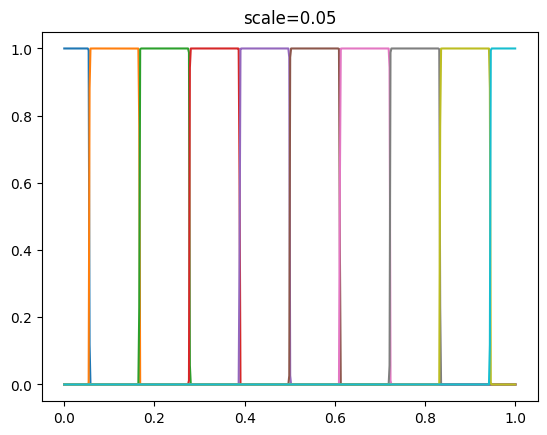

In [1]:
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
class my_gym(gym.Env):
    def __init__(self, render_mode=None):
        super(my_gym,self).__init__()
        self.observation_space = gym.spaces.Box(np.array([0]).astype(np.float32),np.array([1]).astype(np.float32))    

def make_radial_basis_network(env,nvec,scale):
    # env: is the given enviroment
    # nvec: is the given number of grid points in each dimention.
    # scale: is the sigma_c in the equation
    if isinstance(nvec,int):
        nvec = [nvec]*env.observation_space.shape[0]
    
    # This creates a grid of points c_i the lower bound to the upper bound with nvec number of samples in each dimention
    low, high = env.observation_space.low, env.observation_space.high # get upper and lower bound
    assert np.all(np.isfinite(low)) and np.all(np.isfinite(high)), f'infinite bounds on obersvation space are not permitted low={low}, high={high}'
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    dx = np.array([X[1]-X[0] for X in Xvec]) # spacing (related to the B matrix)
    
    def basis_fun(obs):
        #this function should return the vector containing all phi_i of all c_points
        obs = np.array(obs) #(Nobs)
        
        dis = (c_points-obs[None,:])/dx[None,:] #dim = (Nbasis, Nobs)
        exp_arg = np.sum(dis**2,axis=1)/(2*scale**2) #squared distance to every point #b)
        Z = -exp_arg+np.min(exp_arg) #b) for numerical stability you can add the minimum.
        R = np.exp(Z) #b)
        return R/np.sum(R) #b)
    
    return basis_fun #returns a basis function


env = my_gym() #b)
for scale in reversed([0.05, 0.2, 0.5,1.0]): #c)
    f = make_radial_basis_network(env,nvec=10,scale=scale) #c)
    locations = np.linspace(0,1,num=500) #c)
    basis_val = np.array([f([a]) for a in locations]) #c)
    plt.title(f'scale={scale}') #c)
    plt.plot(locations, basis_val) #c)
    plt.show() #c)


**d)** Implement the $\epsilon$-greedy $Q$-learning function provided below using the previously derived update rule. Test this setup on the Mountain Car problem with `nvec=10` and `scale=1.0` of the radial basis function. Visualize the episode lengths returned by the function (tune the other hyperparameters if needed). Additionally, use visualize_theta to plot the maximum $Q$ value in the state-space of the mountain car.

*tip: use `basis_fun(obs).shape[0]` and `env.action_space.n`*  

*tip: use the `roll_mean` function to smooth out the resulting episode lengths*

*Note: A time-out does not qualify as a terminal state, but it does require the environment to be reset. This functionality is already implemented. You can find an explanation [here](https://www.reddit.com/r/reinforcementlearning/comments/bb5mzl/d_confused_about_envis_done/).

scale=1.0 nvec=10
400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 400 319 400 400 400 400 368 400 400 400 400 400 400 400 400 400 400 400 329 353 400 400 400 260 293 400 400 400 400 256 400 400 338 400 264 262 309 400 400 400 260 400 357 400 400 400 400 400 400 400 400 400 324 400 400 291 400 363 391 335 400 252 400 290 299 400 400 240 351 400 312 400 400 227 284 400 400 277 357 400 261 364 400 400 251 296 263 393 351 396 252 246 348 400 302 262 297 400 248 298 242 245 306 376 400 235 285 253 257 248 285 249 314 338 400 336 349 312 256 343 379 301 290 334 249 328 330 285 289 299 292 287 400 288 364 372 252 290 25

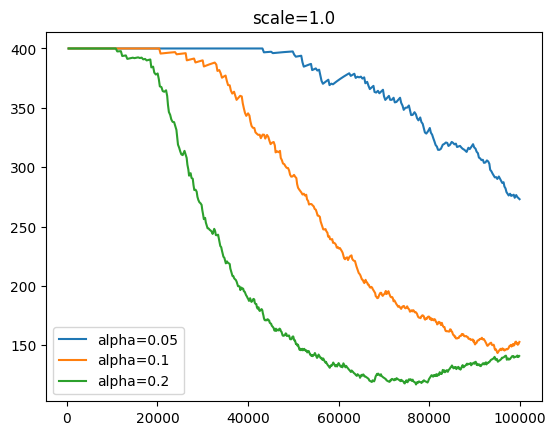

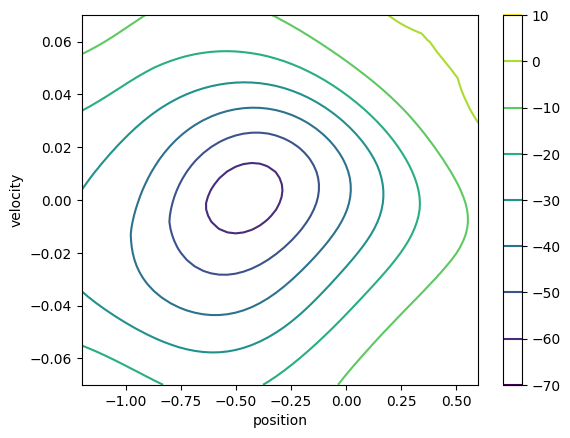

In [2]:
import gymnasium.wrappers
import gymnasium.envs.classic_control
def argmax(a):
    #argmax([0,1,2,3]) -> 3
    #argmax([0,1,2,2]) -> 2 or 3 with equal probability of both (np.argmax would only return 2)
    #argmax([0,0,0,0]) -> 0, 1, 2 or 3 with equal probability of each (np.argmax would only return 0)
    a = np.array(a)
    return np.random.choice(np.arange(a.shape[0],dtype=int)[a==np.max(a)])

import numpy as np
def Qlearn(env, basis_fun, epsilon=0.1, alpha=0.1, gamma=0.99, nsteps=100_000, verbose=True):
    #theta = (Nbasis, Na)
    #basis_fun(state) -> (Nbasis)
    #Q(s,.) = basis_fun(state)@theta
    env_time = env
    while not isinstance(env_time,gym.wrappers.time_limit.TimeLimit):
        env_time = env_time.env
    ep_length = []
    ep_length_id = []
    
    
    obs, info = env.reset() #d=)
    #init theta:
    Nbasis = basis_fun(obs).shape[0] #d=)
    theta = np.zeros((Nbasis, env.action_space.n))#d=)
    
    Q = lambda s: basis_fun(s)@theta #short-hand such that you can call Q(obs)
    
    for z in range(nsteps):
        if np.random.random()<epsilon: #d)
            u = env.action_space.sample() #d)
        else: #d)
            u = argmax(Q(obs)) #d)
        
        obs_next, reward, terminated, truncated, info = env.step(u) #d=)
        
        if terminated:
            TD = Q(obs)[u] - reward #d)
        else:
            TD = Q(obs)[u] - (reward + gamma*np.max(Q(obs_next)))#d)
        
        #update theta
        theta[:,u] -= alpha*TD*basis_fun(obs)#d)
        
        if terminated or truncated:
            if verbose: #print result only when verbose is set to True
                print(env_time._elapsed_steps, end=' ') 
            ep_length.append(env_time._elapsed_steps)#time-keeping
            ep_length_id.append(z)
            
            obs, info = env.reset() #d=)
        else:
            obs = obs_next #d=)
    print()
    return theta, np.array(ep_length_id), np.array(ep_length)

def roll_mean(ar,start=400,N=25):
    s = 1-1/N
    k = start
    out = np.zeros(ar.shape)
    for i,a in enumerate(ar):
        k = s*k + (1-s)*a
        out[i] = k
    return out

def visualize_theta(env, theta, basis_fun):
    # for a given enviroment, theta matrix (Nbasis, Naction) and basis_fun(obs) -> (Nbasis,) 
    # it visualizes the max Q value in state-space.
    low, high = env.observation_space.low, env.observation_space.high
    nvec = [50,60]
    Xvec = [np.linspace(l,h,num=ni) for l,h,ni in zip(low,high,nvec)] # calculate the linspace in all directions
    c_points = np.array(np.meshgrid(*Xvec)) # meshgrid all the linspaces together (Nx, X1, X2, X3, ...) 
    c_points = np.moveaxis(c_points, 0, -1) #transform to (X1, X2, X3, ..., Nobs) 
    c_points = c_points.reshape((-1,c_points.shape[-1])) #flatten into the size (Nc, Nobs)
    maxtheta = np.array([np.max(basis_fun(ci)@theta) for ci in c_points]).reshape((nvec[1],nvec[0]))
    
    plt.contour(Xvec[0],Xvec[1],maxtheta)
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.colorbar()
    plt.show()

max_episode_steps = 400
env = gym.envs.classic_control.MountainCarEnv() 
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) 

scale = 1.0 #d)
nvec = 10 #d)

#e.g. tuning alpha: #d)
for alpha in [0.05, 0.1, 0.2]: #d)
    print(f'scale={scale} nvec={nvec}') #d)
    basis_fun = make_radial_basis_network(env,nvec=nvec,scale=scale)#d=)
    theta, ep_length_id, ep_length = Qlearn(env, basis_fun, epsilon=0.1, alpha=alpha, nsteps=100_000) #d=)
    plt.plot(ep_length_id, roll_mean(ep_length), label=f'alpha={alpha}')#d)
plt.title(f'scale={scale}')#d)
plt.legend()#d)
plt.show()#d)
visualize_theta(env, theta, basis_fun) #d)

**e)** Adjust the `scale` and `nvec` parameters to optimize the agent's convergence towards the desired policy. Compare the tuned `scale` and `nvec` values to those used in the discretized state setup. Additionally, visualize the `theta` values using `visualize_theta` to gain insight into them and use this information to further refine the `scale` and `nvec`.

**Answer e):**  An optimal configuration is achieved with a `scale` of approximately 0.5 and `nvec` set to 5. This setup significantly reduces the number of parameters compared to the discrete state approach with `nvec=10`, while also improving the consistency of optimization. Furthermore, experimenting with lower values, such as `nvec=3` and `scale=0.5`, results in a highly efficient solution for this problem.

scale=0.01 nvec=3



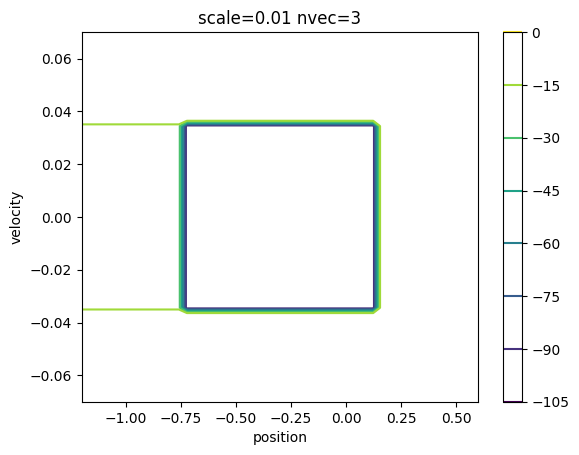

scale=0.01 nvec=5



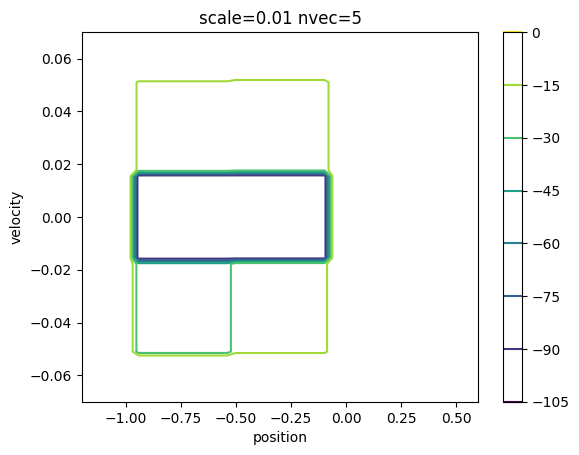

scale=0.01 nvec=10



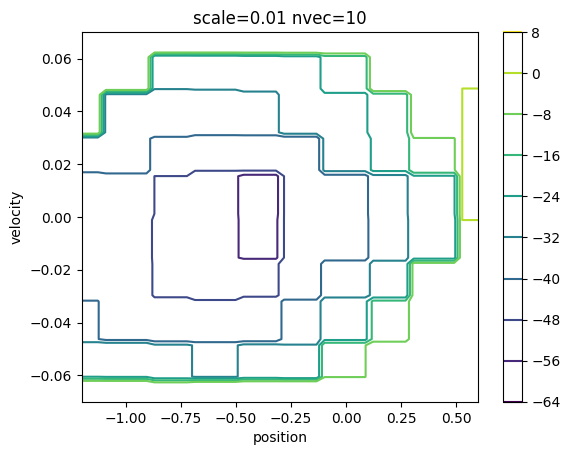

scale=0.01 nvec=15



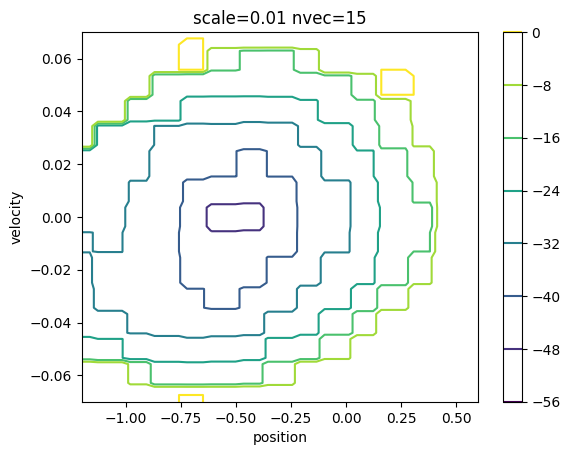

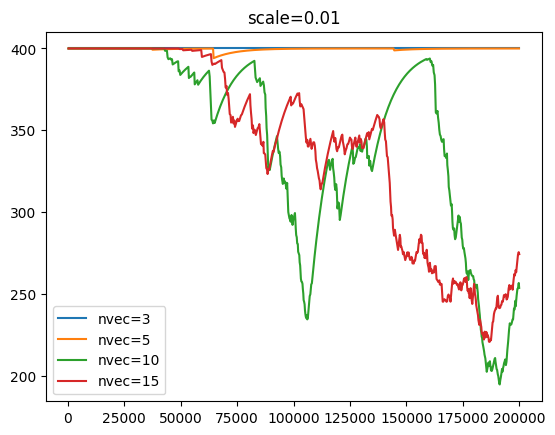

scale=0.25 nvec=3



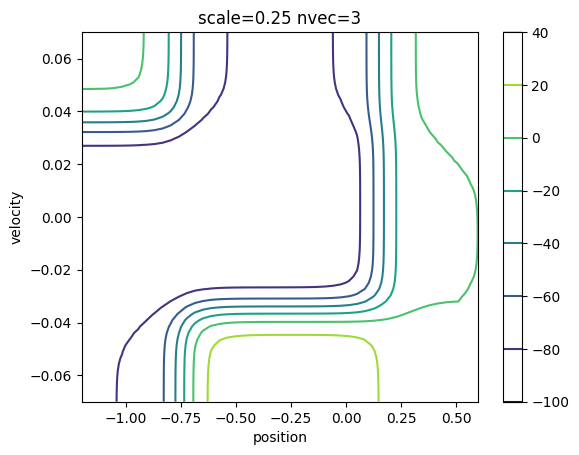

scale=0.25 nvec=5



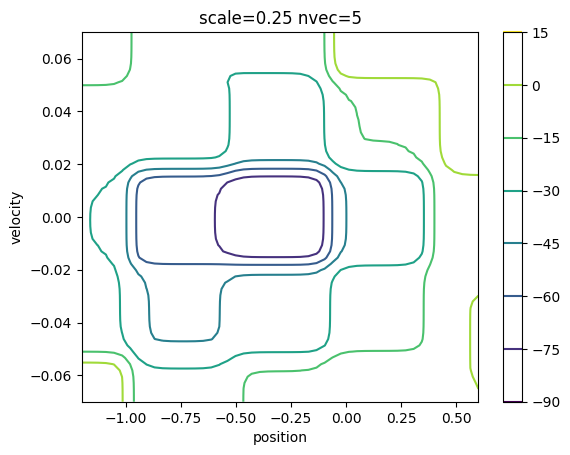

scale=0.25 nvec=10



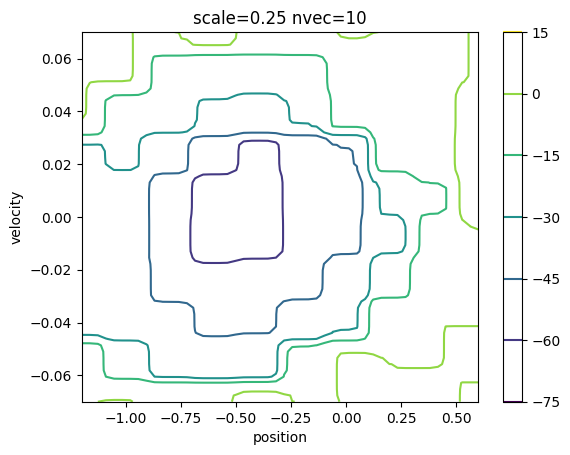

scale=0.25 nvec=15



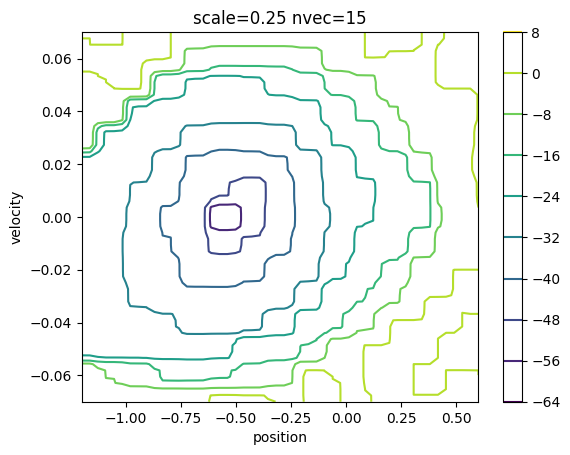

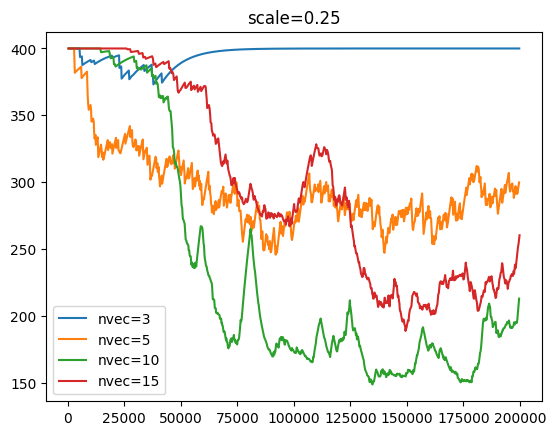

scale=0.5 nvec=3



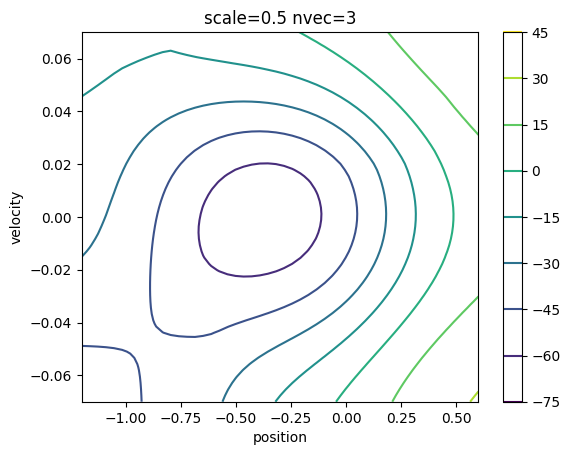

scale=0.5 nvec=5



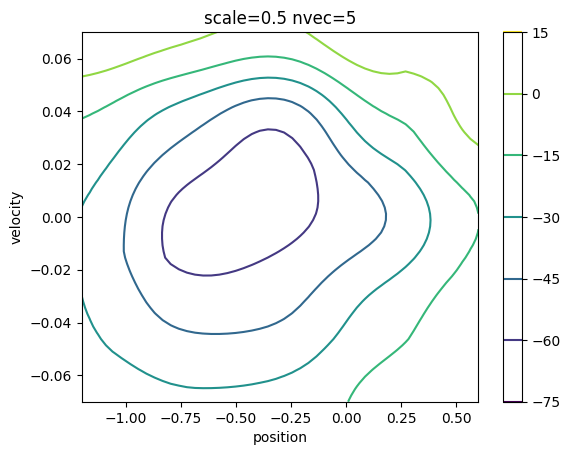

scale=0.5 nvec=10



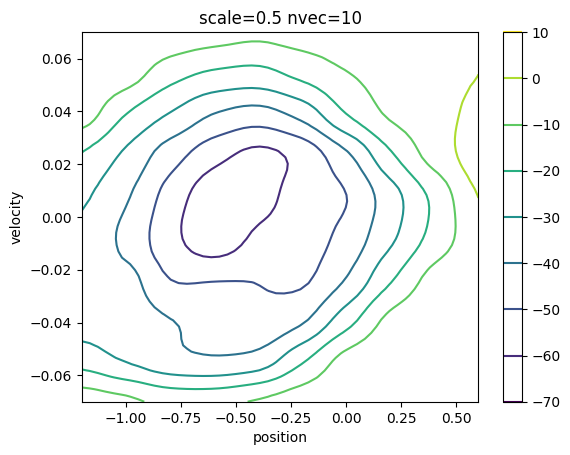

scale=0.5 nvec=15



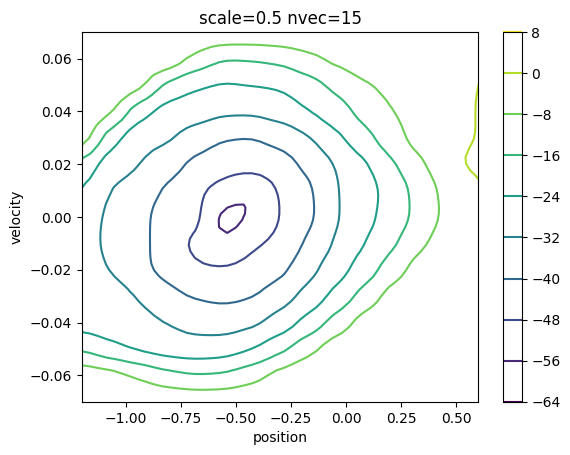

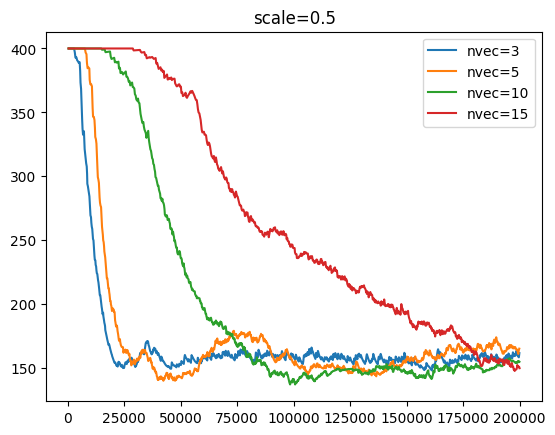

scale=1.0 nvec=3



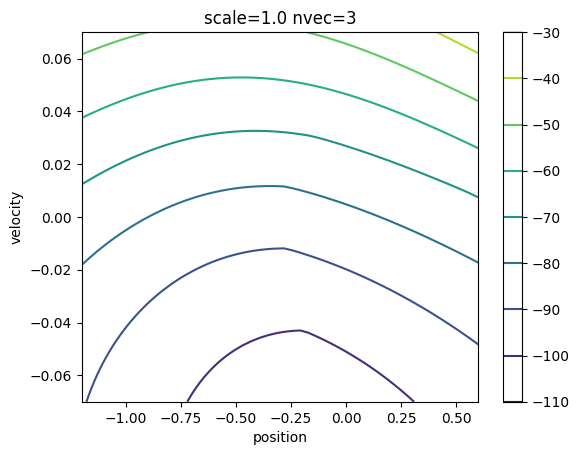

scale=1.0 nvec=5



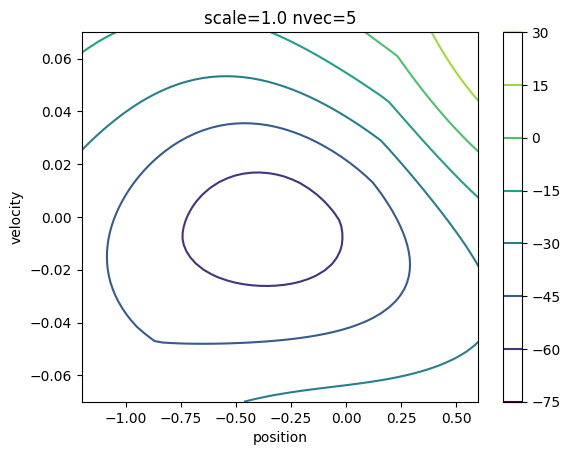

scale=1.0 nvec=10



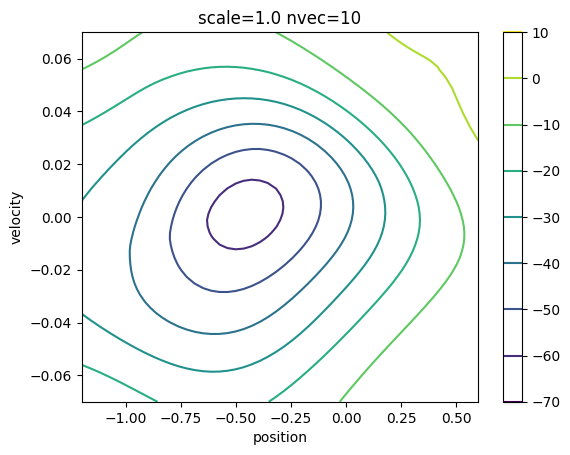

scale=1.0 nvec=15



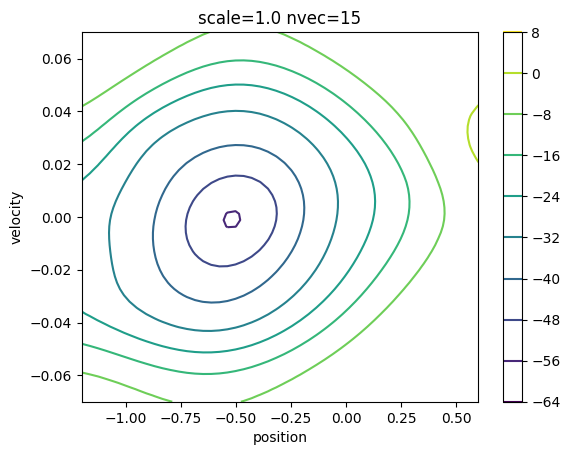

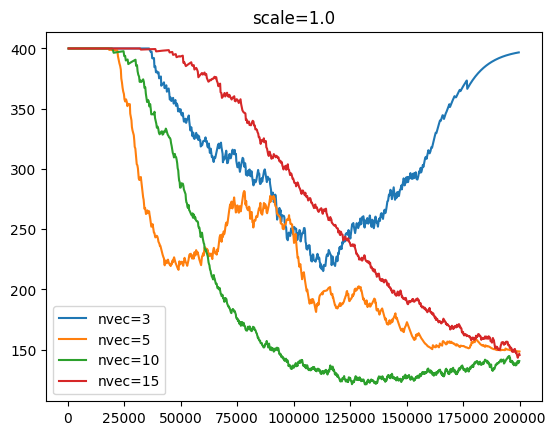

In [3]:
nvec = 10
max_episode_steps = 400
env = gym.envs.classic_control.MountainCarEnv() 
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) 

for scale in [0.01, 0.25, 0.5, 1.0]: #e) 
    ep_lengths_buf = [] #e)
    for nvec in [3,5,10,15]: #e)
        print(f'scale={scale} nvec={nvec}') #e)
        basis_fun = make_radial_basis_network(env,nvec,scale=scale) #e)
        theta, ep_length_id, ep_length = Qlearn(env, basis_fun,nsteps=200_000, verbose=False) #e)
        ep_lengths_buf.append((ep_length_id, ep_length, nvec)) #e)
        plt.title(f'scale={scale} nvec={nvec}') #e)
        visualize_theta(env, theta, basis_fun) #e)
    
    for ep_length_id, ep_length, nvec in ep_lengths_buf: #e)
        plt.plot(ep_length_id, roll_mean(ep_length), label=f'nvec={nvec}') #e)
    plt.title(f'scale={scale}') #e)
    plt.legend() #e)
    plt.show() #e)

## Exercise 2: Deep $Q$-learning

Many standard implementations of deep Q-learning in deep reinforcement learning (DRL) often encounter challenges leading to failures. These failures can typically be attributed to factors such as:

- Instability
- Sparse reward functions
- Overfitting
- And more

To address these issues, various adjustments and techniques are necessary. However, the specific methods employed can vary depending on the problem domain and the preferences of users. These methods can be viewed as a toolbox of strategies tailored to different scenarios and challenges.

For this exercise, you will use the [Acrobat environment](https://gymnasium.farama.org/environments/classic_control/acrobot/)

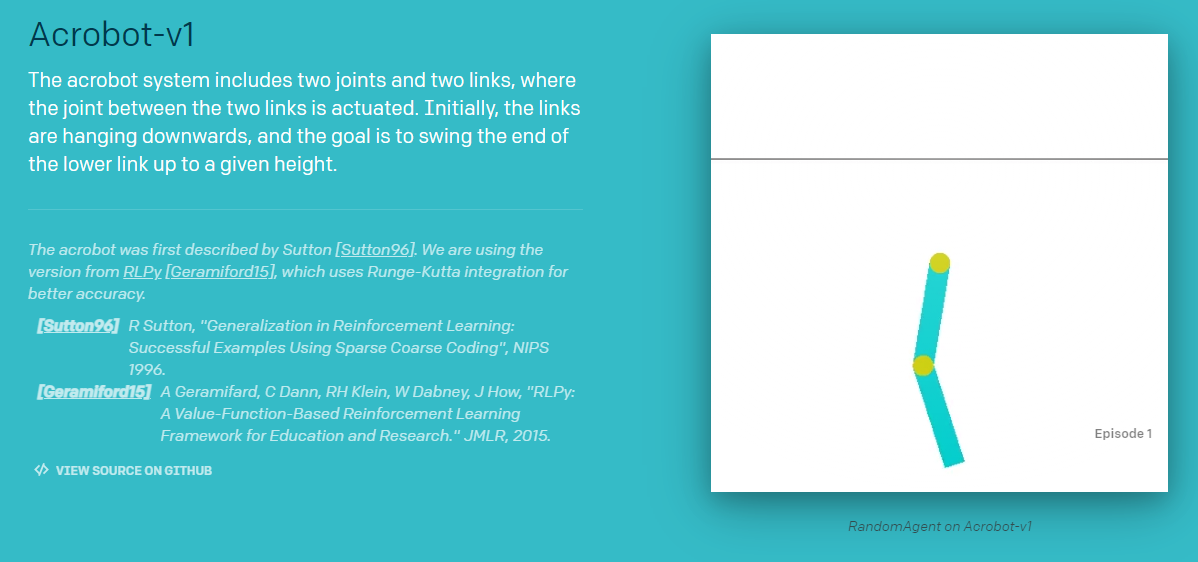

A computationally efficient approach to implement the $Q$ function is to give it the same number of outputs as possible actions. However this is only possible for discrete action spaces (i.e. $u_t \in \{0,...,n_{\text{actions}}-1\}$).

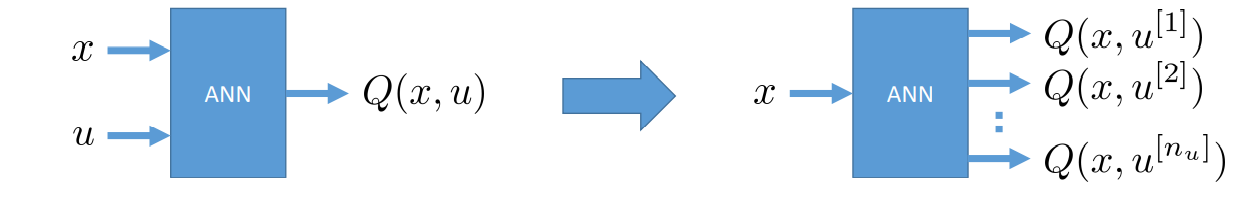


By structuring the Q function in this manner, we can compute all the values of the Q-functions for a given state $x_t$ in a single pass.

**a)** Construct an ANN to serve as our Q-function. Design it with one hidden layer, employ the tanh activation function, and include 40 nodes per layer.

*tip: use env.observation_space.shape[0] and env.action_space.n*  

In [4]:
from torch import nn
import gymnasium as gym
import gymnasium.wrappers
import gymnasium.envs.classic_control
import torch

class Qfunction(nn.Module):
    def __init__(self, env):
        super(Qfunction,self).__init__()
        self.lay1 = nn.Linear(env.observation_space.shape[0], 40) #a)
        self.F1 =  nn.Tanh() #a)
        self.lay2 = nn.Linear(40,env.action_space.n) #a)
    
    def forward(self, obs):
        return self.lay2(self.F1(self.lay1(obs))) #a)

max_episode_steps = 500
env = gym.envs.classic_control.AcrobotEnv()
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) 
Q = Qfunction(env)
#test validity:
obs, info = env.reset()
obs_tensor = torch.tensor(obs,dtype=torch.float32)[None,:] #convert to an torch tensor with size (1, Nobs=6)
print('obs_tensor = ', obs_tensor)
print('Q(x) = ',Q(obs_tensor)) #output #(1,Naction=3)


obs_tensor =  tensor([[ 0.9997, -0.0230,  0.9964, -0.0846,  0.0352,  0.0084]])
Q(x) =  tensor([[-0.0278,  0.1458, -0.0886]], grad_fn=<AddmmBackward0>)


**b)** To visualize the $Q$-function make a `show(Q,env)` function which uses the policy of the $Q$-function 

$$ u_t = \pi(x_t) = \text{arg}\max_{u'} Q_\theta(x_t,u')$$

on a given enviroment `env`. Iterate until the end of the episode (i.e. until `done==True`) and render the results.

*tip: use `np.argmax` to get the element with the highest value, `time.sleep` to introduce a real-time delay and `break` to break from the while loop if done, and of course the `.render` method*


In [5]:
#visualize
import torch, time
import gymnasium as gym
import gymnasium.wrappers, gymnasium.envs.classic_control
import numpy as np
from matplotlib import pyplot as plt
from torch import nn

def show(Q,env):
    with torch.no_grad():
        #you can use Qfun(obs) as a shorthand for the q function.
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() #convert x to torch.tensor -> put in the Q function -> back to numpy
        try:
            obs, info = env.reset() #b)
            env.render() #b)
            time.sleep(1) #b)
            while True: #b)
                action = np.argmax(Qfun(obs)) #b)
                obs, reward, terminated, truncated, info = env.step(action) #b)
                time.sleep(1/60) #b)
                env.render() #b)
                if terminated or truncated: #b)
                    time.sleep(0.5)  #b)
                    break  #b)
        finally: #this will always run even when an error occurs
            env.close()

max_episode_steps = 250
env = gym.envs.classic_control.AcrobotEnv(render_mode='human')
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps) 
Q = Qfunction(env)
# show(Q,env)


Due to the unstable nature of Deep Q-learning, we will be utilizing the rollout/replay buffer structure. This method utilizes a two-step process: 

 1. Applying the policy ($\epsilon$ greedy) to the environment `N_rollout` times and save the results of every step taken.
 [tip: one should save the following results: ($x_t$, $u_t$, $r_{t+1}$, $x_{t+t}$, $\text{terminal}_{t+1}$)]

 2. Use batch optimization on the results obtained on the TD Loss 
 $$ Loss = \frac{1}{N_{rollout}} \sum_t \left (r_{t+1} + \gamma \max_{u'} Q_\theta(x_{t+1},u') (1-\text{terminal}_{t+1}) - Q_\theta(x_{t},u_{t}) \right )^2$$ 
 where the $\max_{u'} Q_\theta(x_{t+1},u')$ is excluded from the gradient calculation. 

 
**c)** Finish the rollout function with the $\epsilon$-greedy algorithm. 

*tip: use `Qfun` present which can take in an `obs` and will give all the Q values in a simple NumPy array*

In [6]:
def rollout(Q, env, epsilon=0.1, N_rollout=10_000): 
    #save the following (use .append)
    Start_state = [] #hold an array of (x_t)
    Actions = [] #hold an array of (u_t)
    Rewards = [] #hold an array of (r_{t+1})
    End_state = [] #hold an array of (x_{t+1})
    Terminal = [] #hold an array of (terminal_{t+1})
    # Qfun( a numpy array of the obs) -> a numpy array of Q values
    Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy() 
    with torch.no_grad():
        
        obs, info = env.reset() #c)
        for i in range(N_rollout): #c)
            if np.random.uniform()>epsilon: #c)
                Qnow = Qfun(obs) #c)
                action = np.argmax(Qnow) #c)
            else: #c)
                action = env.action_space.sample() #c)
            Start_state.append(obs) #c)
            Actions.append(action) #c)

            obs_next, reward, terminated, truncated, info = env.step(action) #c)

            Terminal.append(terminated) #c)
            Rewards.append(reward) #c)
            End_state.append(obs_next) #c)

            if terminated or truncated: #c)
                obs, info = env.reset() #c)
            else: #c)
                obs = obs_next #c)
                
    #error checking:
    assert len(Start_state)==len(Actions)==len(Rewards)==len(End_state)==len(Terminal), f'error in lengths: {len(Start_state)}=={len(Actions)}=={len(Rewards)}=={len(End_state)}=={len(Dones)}'
    return np.array(Start_state), np.array(Actions), np.array(Rewards), np.array(End_state), np.array(Terminal).astype(int)

max_episode_steps = 250
env = gym.envs.classic_control.AcrobotEnv()
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
Q = Qfunction(env) 
Start_state, Actions, Rewards, End_state, Terminal = rollout(Q,env,N_rollout=300)
print(Start_state, Actions, Rewards, End_state, Terminal)

[[ 0.9962338   0.0867075   0.998009    0.06307163  0.00910427  0.02248333]
 [ 0.9968643   0.07913014  0.9976188   0.06896924 -0.08333006  0.03431195]
 [ 0.9984915   0.05490596  0.9971655   0.07523914 -0.15427747  0.02361245]
 ...
 [ 0.99973834 -0.02287607  0.9931039   0.11723743 -0.07183179  0.26336834]
 [ 0.99950737 -0.03138556  0.9882078   0.15311845 -0.01062147  0.09159277]
 [ 0.999643   -0.02671816  0.9883586   0.15214227  0.05622835 -0.10037515]] [1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 

During training, we want to evaluate the policy resulting from the current $Q$-function to accurately assess its performance and for early stopping. This is done by calculating the accumulated rewards on an episode [note: averages will be taken later].

**d)** Finish writing `eval_Q` which returns the accumulated sum of the rewards for a single episode. ($\gamma=1$, $\epsilon=0$)

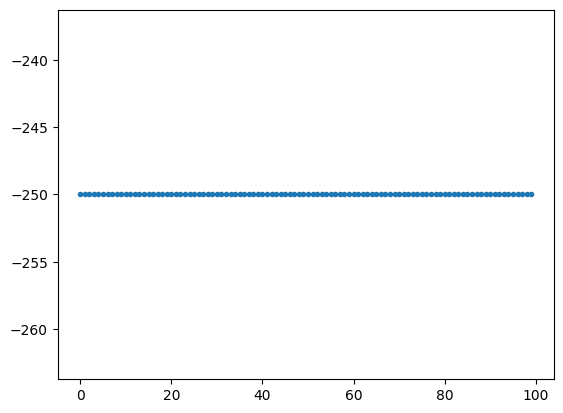

In [7]:
from matplotlib import pyplot as plt

def eval_Q(Q,env):
    with torch.no_grad():
        Qfun = lambda x: Q(torch.tensor(x[None,:],dtype=torch.float32))[0].numpy()
        rewards_acc = 0 #d)
        obs, info = env.reset() #d)
        while True: #d)
            action = np.argmax(Qfun(obs)) #d)
            obs, reward, terminated, truncated, info = env.step(action) #d)
            rewards_acc += reward #d)
            if terminated or truncated: #d)
                return rewards_acc #d)

max_episode_steps = 250
env = gym.envs.classic_control.AcrobotEnv()
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)
Q = Qfunction(env) 
plt.plot([eval_Q(Q,env) for i in range(100)],'.') #d)
plt.show() #d)


Now we have written all the utility functions to implement a rollout deep Q-learning algorithm. 

**e)** Use the previously written utility functions to create the DQN Algorithm. This algorithm requires the following steps:

 1. Realize an $\epsilon$ factor which decays linearly from 1 to 0 with the number of iterations.
 2. Use the rollout function to produce the `Start_state, Actions, Rewards, End_state, Terminal` (do not forget to pass the hyperparameters)
 3. Use batch optimization on the Loss given by:
 $$Loss = \sum_t \left (r_{t+1} + \gamma \max_{u'} Q_{\theta\text{ no grad}} (x_{t+1},u') (1-\text{done}_{t+1}) - Q_\theta(x_{t},u_{t}) \right )^2$$
 where $\max_{u'} Q_{\theta\text{ no grad}} (x_{t+1},u')$ is excluded from the gradient calculation. (use `torch.no_grad()` or `.detach()`)
 
 4. Each epoch of the batch optimization evaluates the policy from the Q-function using the previously written `Q_eval(Q,env)` function and saves the result if it is the highest observed (averaged over `N_evals` episodes). 
 5. At the end of each iteration load the best performing Q function previously saved [this is already present].

In [8]:


from copy import deepcopy
def DQN_rollout(Q, optimizer, env, gamma=0.98, use_target_net=False, N_iterations=21, N_rollout=20000, \
                N_epochs=10, batch_size=32, N_evals=10, target_net_update_feq=100):
    best = -float('inf')
    torch.save(Q.state_dict(),'Q-checkpoint')
    try:
        for iteration in range(N_iterations):
            epsilon = 1.0 - iteration/(N_iterations-1) #e=) 1.
            print(f'rollout iteration {iteration} with epsilon={epsilon:.2%}...')
            
            #2. rollout
            Start_state, Actions, Rewards, End_state, Terminal = rollout(Q, env, epsilon=epsilon, N_rollout=N_rollout) #e) 2.
            
            #Data conversion, no changes required
            convert = lambda x: [torch.tensor(xi,dtype=torch.float32) for xi in x]
            Start_state, Rewards, End_state, Terminal = convert([Start_state, Rewards, End_state, Terminal])
            Actions = Actions.astype(int)

            print('starting training on rollout information...')
            t = 0
            for epoch in range(N_epochs): 
                for i in range(batch_size,len(Start_state)+1,batch_size): 
                    if t%target_net_update_feq==0:
                        Qtarget = deepcopy(Q) #g)
                        pass
                    t += 1
                    
                    Start_state_batch, Actions_batch, Rewards_batch, End_state_batch, Terminal_batch = [d[i-batch_size:i] for d in \
                                                                                                        [Start_state, Actions, Rewards, End_state, Terminal]] #e=) 3.
                    
                    with torch.no_grad(): #3.
                        if use_target_net:
                            pass
                            maxQ = torch.max(Qtarget(End_state_batch),dim=1)[0] #g)
                        else:
                            maxQ = torch.max(Q(End_state_batch),dim=1)[0] #e=) 3.
                    
                    # action_index = np.stack((np.arange(batch_size),Actions_batch),axis=0)
                    # ids = np.arange(batch_size)
                    
                    Qnow = Q(Start_state_batch)
                    # print(f'{action_index.shape=}')
                    # print(f'{Qnow.shape=}')
                    Qnow = Qnow[np.arange(batch_size), Actions_batch] #Q(x_t,u_t) is given
                    # print(Rewards_batch.shape, maxQ.shape, Terminal_batch.shape, Qnow.shape)
                    Loss = torch.mean((Rewards_batch + gamma*maxQ*(1-Terminal_batch) - Qnow)**2) #e) 3.
                    optimizer.zero_grad() #e) 3.
                    Loss.backward() #e) 3.
                    optimizer.step() #e) 3.
                
                score = np.mean([eval_Q(Q,env) for i in range(N_evals)]) #e=) 3.
                
                print(f'iteration={iteration} epoch={epoch} Average Reward per episode:',score)
                if score>best:
                    best = score
                    print('################################# \n new best',best,'saving Q... \n#################################')
                    torch.save(Q.state_dict(),'Q-checkpoint')
            
            print('loading best result')
            Q.load_state_dict(torch.load('Q-checkpoint'))
    finally: #this will always run even when using the a KeyBoard Interrupt. 
        print('loading best result')
        Q.load_state_dict(torch.load('Q-checkpoint'))

**f)** Apply your implementation to the `AcrobotEnv` environment. Experiment with the hyperparameters to observe their effects on the resulting performance. Evaluate the resulting policies visually using the `show` function and with the `eval` function as demonstrated in the next two cells.

In [9]:
import torch
from torch import nn
import gymnasium as gym

max_episode_steps = 250
env = gym.envs.classic_control.AcrobotEnv()
env = gym.wrappers.time_limit.TimeLimit(env,max_episode_steps=max_episode_steps)


gamma = 0.98 #f=)
batch_size = 32 #f=)
N_iterations = 21 #f=)
N_rollout = 20000 #f=)
N_epochs = 10 #f=)
N_evals = 5 #f=)
lr = 0.0005 #given

assert isinstance(env.action_space,gym.spaces.Discrete), 'action space requires to be discrete'
Q = Qfunction(env)
optimizer = torch.optim.Adam(Q.parameters(),lr=lr) #low learning rate
DQN_rollout(Q, optimizer, env, use_target_net=True, gamma=gamma, N_iterations=N_iterations, \
            N_rollout=N_rollout, N_epochs=N_epochs, N_evals=N_evals)

rollout iteration 0 with epsilon=100.00%...
starting training on rollout information...
iteration=0 epoch=0 Average Reward per episode: -250.0
################################# 
 new best -250.0 saving Q... 
#################################
iteration=0 epoch=1 Average Reward per episode: -154.0
################################# 
 new best -154.0 saving Q... 
#################################
iteration=0 epoch=2 Average Reward per episode: -80.0
################################# 
 new best -80.0 saving Q... 
#################################
iteration=0 epoch=3 Average Reward per episode: -84.8
iteration=0 epoch=4 Average Reward per episode: -77.8
################################# 
 new best -77.8 saving Q... 
#################################
iteration=0 epoch=5 Average Reward per episode: -78.0
iteration=0 epoch=6 Average Reward per episode: -88.0
iteration=0 epoch=7 Average Reward per episode: -83.4
iteration=0 epoch=8 Average Reward per episode: -76.4
##############################

In [11]:
%pip install pygame -q

Note: you may need to restart the kernel to use updated packages.


In [12]:
env_vis = gym.envs.classic_control.AcrobotEnv(render_mode='human')
env_vis = gym.wrappers.time_limit.TimeLimit(env_vis,max_episode_steps=max_episode_steps)

show(Q,env_vis)

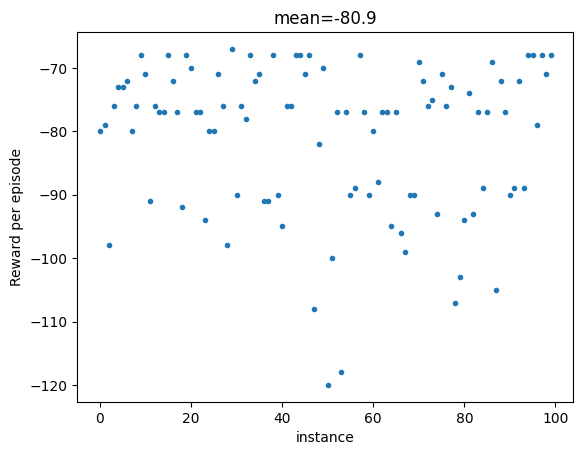

In [13]:
from matplotlib import pyplot as plt
Rewards = [eval_Q(Q,env) for i in range(100)]
plt.plot(Rewards,'.')
plt.title(f'mean={np.mean(Rewards)}')
plt.xlabel('instance')
plt.ylabel('Reward per episode')
plt.show()

**g)** In the lecture, you learned about another method to enhance the stability of DQN by incorporating a target network that is updated only occasionally. Implement this in the function above, where the target network is update after each epoch.

*tip: use `deepcopy` to make a copy of the current network*

**h)** Summarize the number of hyperparameters exlcuding the ANN structure. 

**Answer h):** Next week we will introduce Actor Critic methods which are much more stable and the hyperparameters are more lenient. 

**i)** **Bonus**If you're up for an additional challenge, you can rerun the code with any discrete-input environment. See [classic control](https://gymnasium.farama.org/environments/classic_control/) which includes:

 * [Cart Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/)
 * [Mountain Car](https://gymnasium.farama.org/environments/classic_control/mountain_car/)
 * and the design assignment (update the reward function)

You may need to adjust the hyperparameters to suit the chosen environment. Alternatively, you can create your own environment, which offers a more tailored approach. See: https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e

### Quick last note

It's worth mentioning that *state normalization* is a popular method in reinforcement learning, although it wasn't covered in this exercise set.